In [1]:
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from holoanalytics import definitions as df
from holoanalytics.utils import importing
from holoanalytics.datapreparation import reformatting as reform
from holoanalytics.datavisualization import formatting as format

In [ ]:
importing.request_session()

In [3]:
# Change Pandas display settings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', None)

In [4]:
member_data = importing.import_member_data()
member_channel_data = importing.import_channel_data()
member_video_data = importing.import_video_data()

member_channel_data, member_video_data = reform.reformat_datetimes(member_channel_data, member_video_data)

GROUPS_BRANCHES_UNITS =  importing.get_groups_branches_units(member_data)

In [5]:
def channel_stats_correlation(member_data, member_channel_data):
    title_size = 11
    title_weight = 'bold'
    label_weight='bold'
    scale = 1_000_000

    data = member_data.merge(member_channel_data['channel_stats']['data'], left_on='youtube_channel_id', right_on='channel_id')
    max_y_value = data['view_count'].max()

    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(11, 8.5)

    axes[0].scatter(x=data['subscriber_count']/scale, y=data['view_count']/scale)
    axes[0].set_xlabel('Subscriber Count (millions)', fontweight=label_weight)
    axes[0].set_ylabel('View Count (millions)', fontweight=label_weight)
    axes[0].set_title('View Count vs. Subscriber Count', fontsize=title_size, fontweight=title_weight)
    format.set_upper_limits(axes[0], max_x=data['subscriber_count'].max()/scale, max_y=data['view_count'].max()/scale)


    axes[1].scatter(x=data['video_count'], y=data['subscriber_count']/scale)
    axes[1].set_xlabel('Video Count', fontweight=label_weight)
    axes[1].set_ylabel('Subscriber Count (millions)', fontweight=label_weight)
    axes[1].set_title('Subscriber Count vs. Video Count', fontsize=title_size, fontweight=title_weight)
    format.set_upper_limits(axes[1], max_x=data['video_count'].max(), max_y=data['subscriber_count'].max()/scale)

    axes[2].scatter(x=data['video_count'], y=data['view_count']/scale)
    axes[2].set_xlabel('Video Count', fontweight=label_weight)
    axes[2].set_ylabel('View Count (millions)', fontweight=label_weight)
    axes[2].set_title('View Count vs. Video Count', fontsize=title_size, fontweight=title_weight)
    axes[2].yaxis.set_label_position('right')
    axes[2].yaxis.tick_right()
    format.set_upper_limits(axes[2], max_x=data['video_count'].max(), max_y=data['view_count'].max()/scale)

    for index, _ in enumerate(axes):
        axes[index].get_xaxis().get_major_formatter().set_scientific(False)
        axes[index].get_yaxis().get_major_formatter().set_scientific(False)
        axes[index].tick_params(axis='x', rotation=90)
        axes[index].set_xlim(0)
        axes[index].set_ylim(0)

    fig.suptitle('Correlation of Subscriber, Video, and View Counts of Hololive Production Members', 
                fontsize=13, fontweight=title_weight)
    fig.tight_layout()

    plt.show()

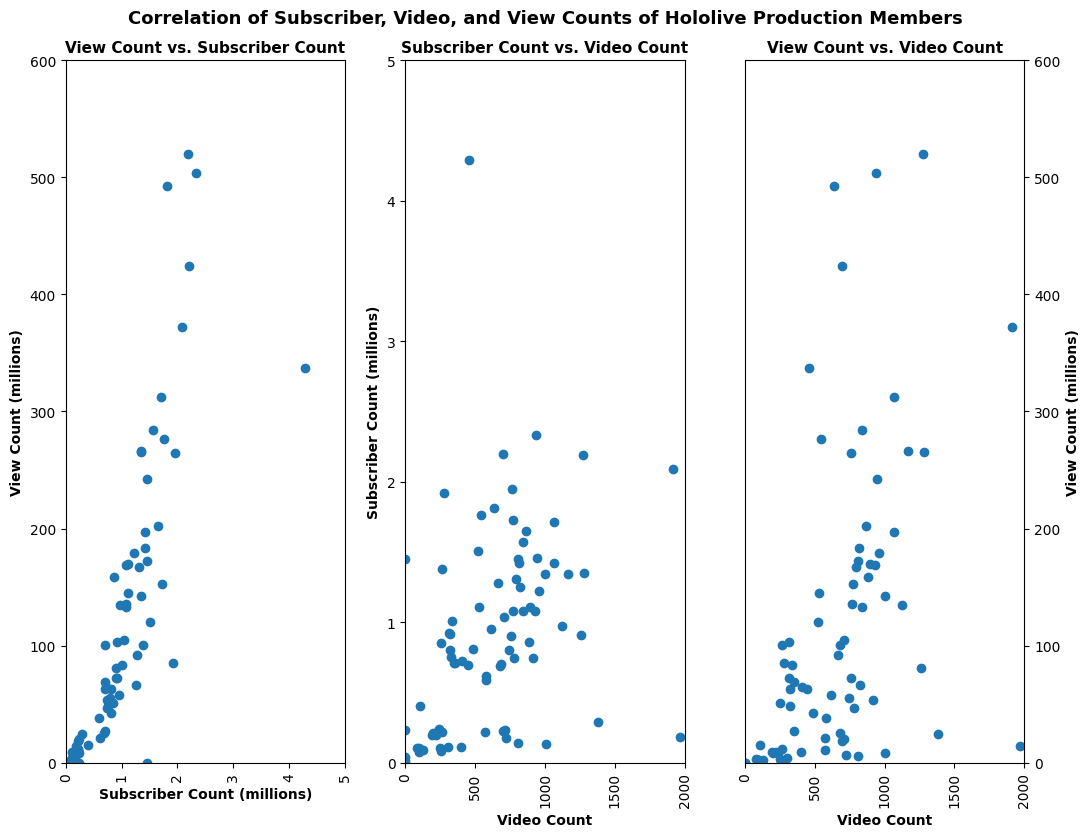

In [6]:
channel_stats_correlation(member_data, member_channel_data)

In [7]:
def total_video_duration(member_data, channel_video_summary, unit_time='hours', sort=None):
    title_weight = 'bold'
    label_weight = 'bold'
    unit_time_label = string.capwords(unit_time)

    # Prepare Data
    member_data_multilevel = reform.convert_to_multilevel(member_data, 'member_data')
    merged_data = member_data_multilevel.merge(channel_video_summary, 
                                               on=[('member_data', 'name')])
    data = merged_data[[('member_data', 'name'), ('video_attributes', 'video_duration_(sum)')]].copy()
    data[('video_attributes', 'video_duration_(sum)')] = data[('video_attributes', 'video_duration_(sum)')].apply(reform.convert_timedelta, unit=unit_time)

    if sort is None: 
        pass
    elif not isinstance(sort, str):
        raise TypeError("The argument for the 'sort' parameter needs to be None or a string with a value of 'ascending' or 'descending'.")
    elif sort.lower() == 'ascending':
        data.sort_values(('video_attributes', 'video_duration_(sum)'), ascending=True, inplace=True)
    elif sort.lower() == 'descending':
        data.sort_values(('video_attributes', 'video_duration_(sum)'), ascending=False, inplace=True)
    else:
        raise ValueError("The argument for the 'sort' parameter is a string but needs to be 'ascending' or 'descending'.")

    # Create Plot
    fig, ax = plt.subplots()
    ax.bar(x=data[('member_data', 'name')], height=data[('video_attributes', 'video_duration_(sum)')])

    # Format Plot
    fig.set_size_inches(8.5, 11)
    fig.suptitle(f'Number of {unit_time_label} of Video Content of Hololive Production Members',
                 fontweight=title_weight)
    fig.tight_layout()

    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('Members', fontweight=label_weight)
    ax.set_ylabel(f'Number of {unit_time_label}', fontweight=label_weight)
    format.set_upper_limits(ax, max_y=data[('video_attributes', 'video_duration_(sum)')].max())


    plt.show()

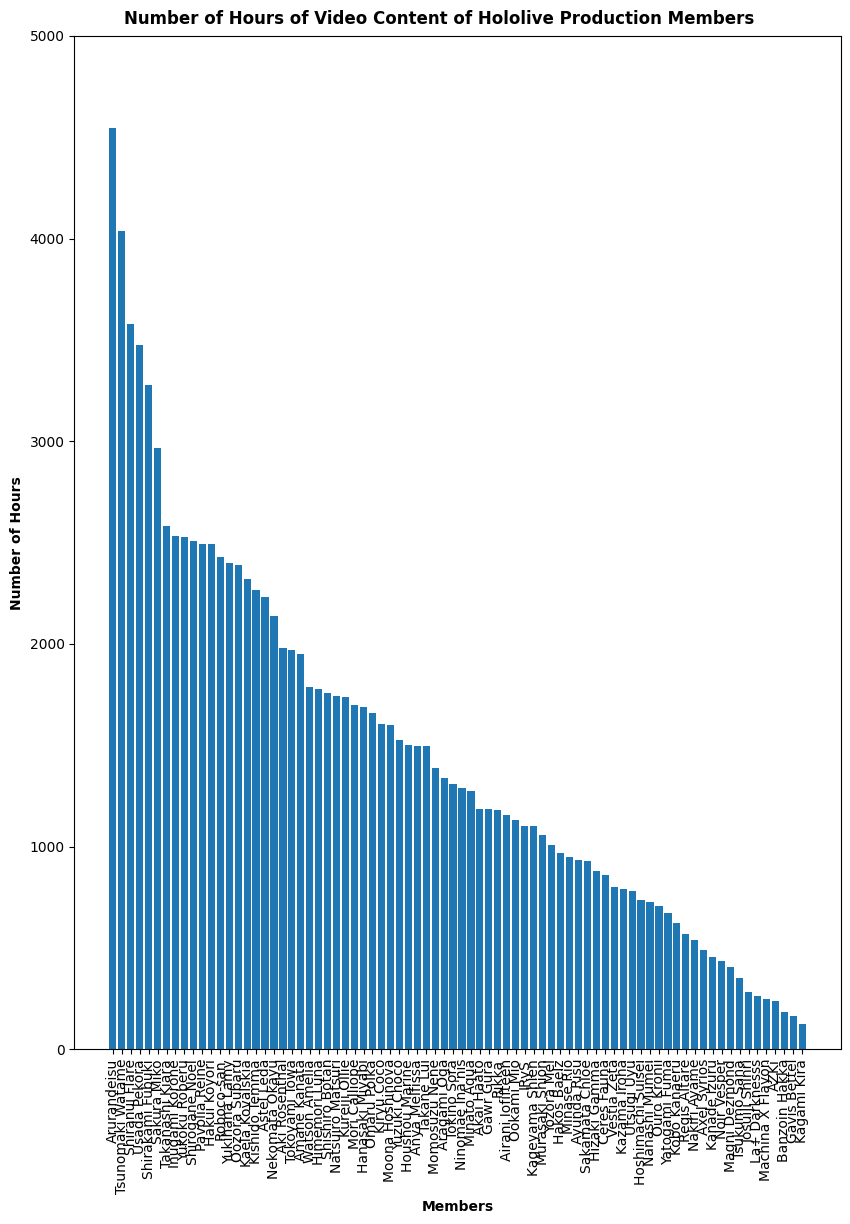

In [8]:
total_video_duration(member_data, member_channel_data['channel_video_summary']['data'], sort='descending')

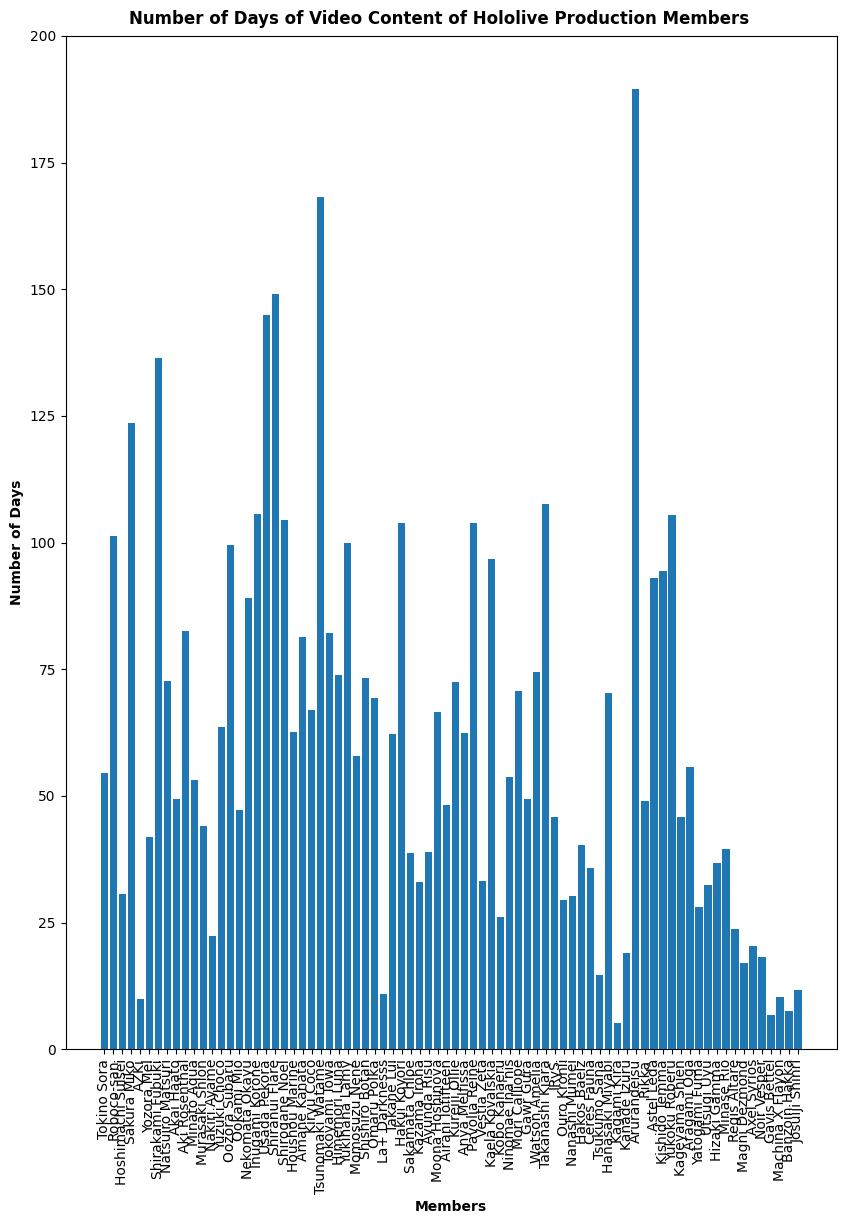

In [9]:
total_video_duration(member_data, member_channel_data['channel_video_summary']['data'], unit_time='days')

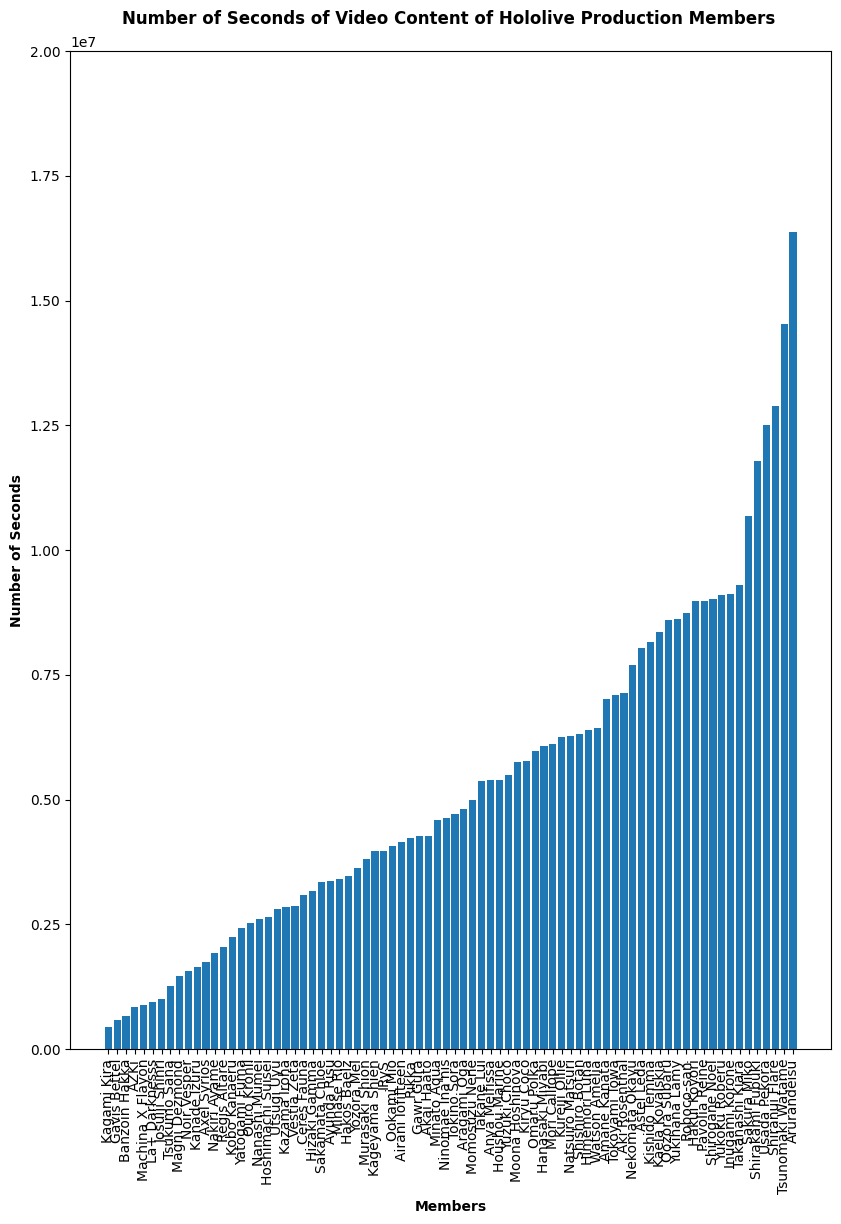

In [10]:
total_video_duration(member_data, member_channel_data['channel_video_summary']['data'], unit_time='seconds', sort='ascending')

In [11]:
def video_types(channel_video_summary, live_broadcasts=True, non_live_broadcasts=True): 
    title_weight = 'bold'
    label_weight = 'bold'
    requested_types = []

    # Prepare Data
    data = channel_video_summary.copy()

    if live_broadcasts is True:
        requested_types += ['live_stream', 'premiere']
    if non_live_broadcasts is True:
        requested_types += ['normal', 'short']

    video_type_counts = [video_type + '_(count)' for video_type in requested_types]
    max_y = data['video_types'][video_type_counts].max().max()

    # Create Plot
    fig, ax = plt.subplots()

    for video_type_count in data['video_types'].columns:
        video_type = video_type_count[:-8]
        if video_type in requested_types:
            ax.bar(x=data[('member_data', 'name')], height=data[('video_types', video_type_count)], 
                   label=video_type.replace('_', ' ').title())

    # Format Plot
    fig.set_size_inches(8.5, 11)
    fig.suptitle('Number of Videos Based on Video Types', fontweight=title_weight)
    fig.tight_layout()

    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('Member', fontweight=label_weight)
    ax.set_ylabel('Number of Videos', fontweight=label_weight)
    ax.legend()
    format.set_upper_limits(ax, max_y=max_y)

    plt.show()

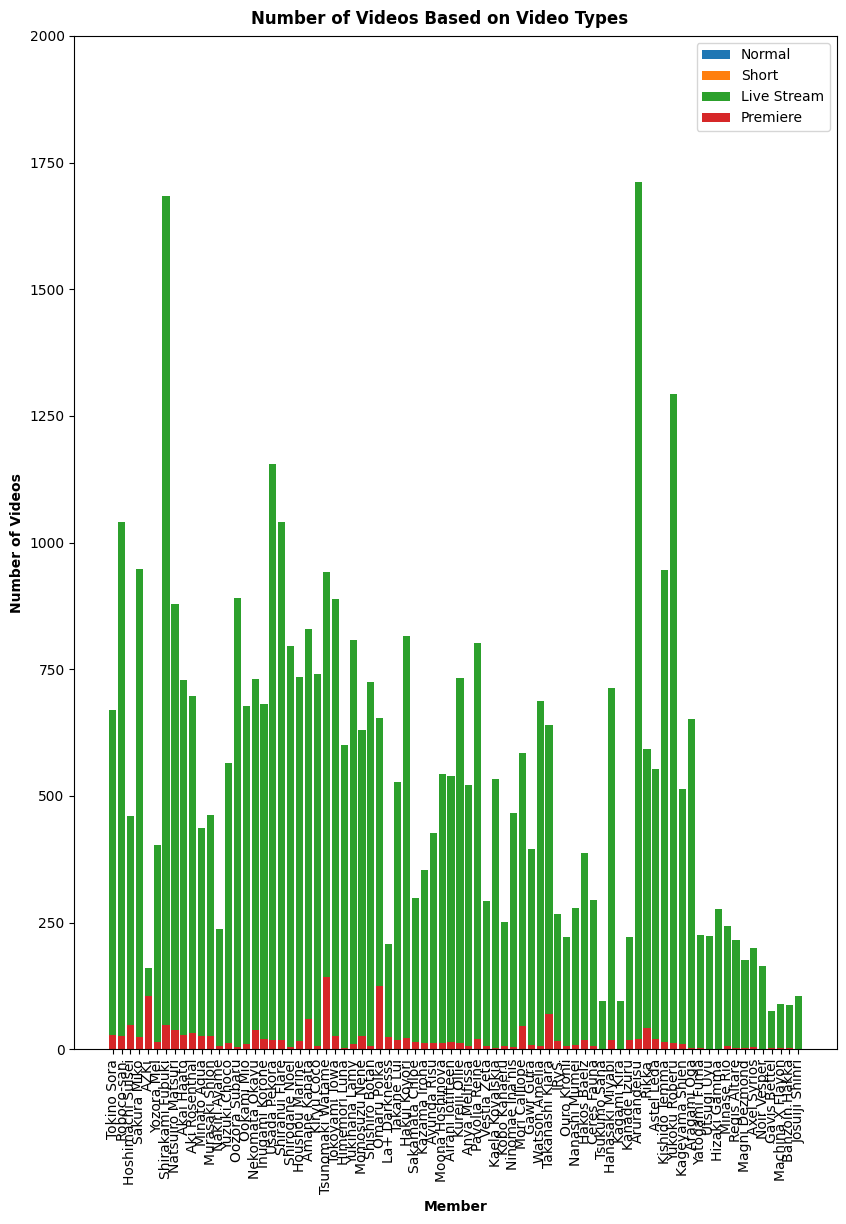

In [12]:
video_types(member_channel_data['channel_video_summary']['data'])

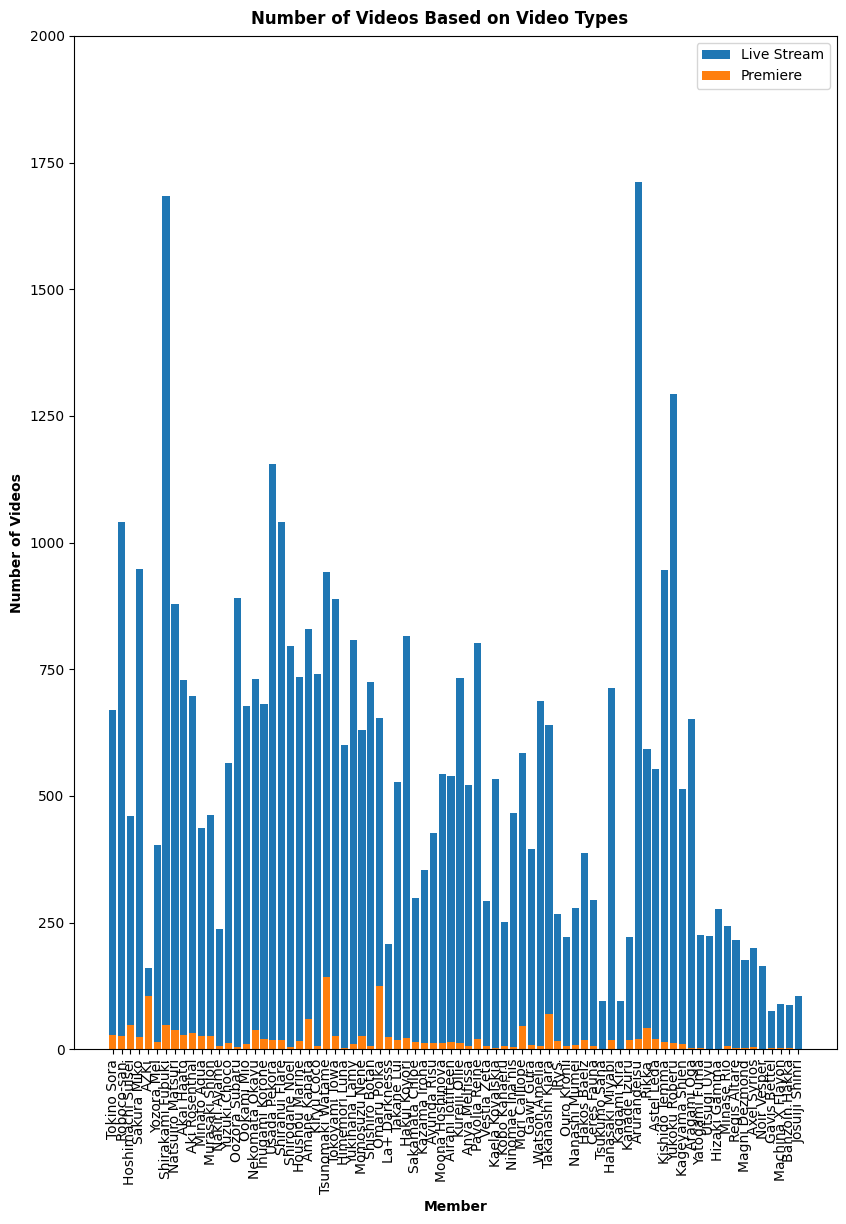

In [13]:
video_types(member_channel_data['channel_video_summary']['data'], live_broadcasts=True, non_live_broadcasts=False)

In [14]:
def channel_stats_by_unit(member_channel_data, group, branch, show):

    if show.lower() == 'percentage':
        _channel_stats_by_unit_percentage(member_channel_data, group, branch)
    elif show.lower() == 'count':
        _channel_stats_by_unit_count(member_channel_data, group, branch)


def _channel_stats_by_unit_percentage(member_channel_data, group, branch):
    title_weight = 'bold'
    label_weight = 'bold'
    ticklabel_weight = 'bold'
    
    data_cols = ['subscriber_percent', 'video_percent', 'view_percent']

    group = group.title()
    branch = branch.title()
    
    # Prepare Data
    unit_summary_data = member_channel_data['unit_summary']['data']

    branch_data = unit_summary_data.loc[(unit_summary_data['group'] == group) & 
                                        (unit_summary_data['branch'] == branch)].copy().reset_index()

    branch_data['subscriber_percent'] = branch_data['subscriber_count'] / branch_data['subscriber_count'].sum() * 100
    branch_data['video_percent'] = branch_data['video_count'] / branch_data['video_count'].sum() * 100
    branch_data['view_percent'] = branch_data['view_count'] / branch_data['view_count'].sum() * 100

    # Create Plot
    fig, ax = plt.subplots()
    fig.set_size_inches(8.5, 11)

    previous_values = np.array([0,0,0])
    for index, row in branch_data.iterrows():
        unit = row['unit']
        values = row[data_cols]
        ax.bar(x=['Subscriber Count', 'Video Count', 'View Count'], height=values, bottom=previous_values, label=unit.replace('_', ' '))
        previous_values = previous_values + np.array(values.copy())

    # Format Plot
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.suptitle(f'{group} {branch}:\nPercentages of Subscribers, Videos, and Views by Unit', fontweight=title_weight)
    fig.tight_layout()

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), bbox_to_anchor=(1, 0.5), loc='center left', title='$\\bf{Units}$')
    ax.set_xticks(ax.get_xticks())  # Removes "UserWarning: FixedFormatter should only be used together with FixedLocator"
    ax.set_xticklabels(ax.get_xticklabels(), weight=ticklabel_weight)

    for index, container in enumerate(ax.containers):
        labels = [f'{value:.2f}%' for value in branch_data.loc[index, data_cols]]
        ax.bar_label(container, labels=labels)

    ax.set_ylabel('Percentage (%)', fontweight=label_weight)

    plt.show()


def _channel_stats_by_unit_count(member_channel_data, group, branch):
    title_weight = 'bold'
    label_weight = 'bold'
    ticklabel_weight = 'bold'

    group = group.title()
    branch = branch.title()

    # Prepare Data
    unit_summary_data = member_channel_data['unit_summary']['data']

    branch_data = unit_summary_data.loc[(unit_summary_data['group'] == group) & 
                                        (unit_summary_data['branch'] == branch)].copy().reset_index()

    # Create Plot
    bars = []
    data_cols = ['subscriber_count', 'video_count', 'view_count']

    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(8.5, 11)


    for ax, data_col in zip(axes, data_cols):
        bars.append(ax.bar(branch_data['unit'] , branch_data[data_col]))


    # Format Plot
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.suptitle(f'{group} {branch}:\nSubscriber, Video, and View Counts by Unit', fontweight=title_weight)
    fig.tight_layout()

    for ax, data_col in zip(axes, data_cols):
        ax.set_title(data_col.replace('_', ' ').title())
        ax.tick_params(axis='x', rotation=90)
        ax.set_xticks(ax.get_xticks())  # Removes "UserWarning: FixedFormatter should only be used together with FixedLocator"
        ax.set_xticklabels(ax.get_xticklabels(), weight=ticklabel_weight)
        format.set_upper_limits(ax, max_y=branch_data[data_col].max())

    for index, ax in enumerate(axes):
        ax.bar_label(bars[index], rotation=90, fontweight=label_weight)

    plt.show()
    

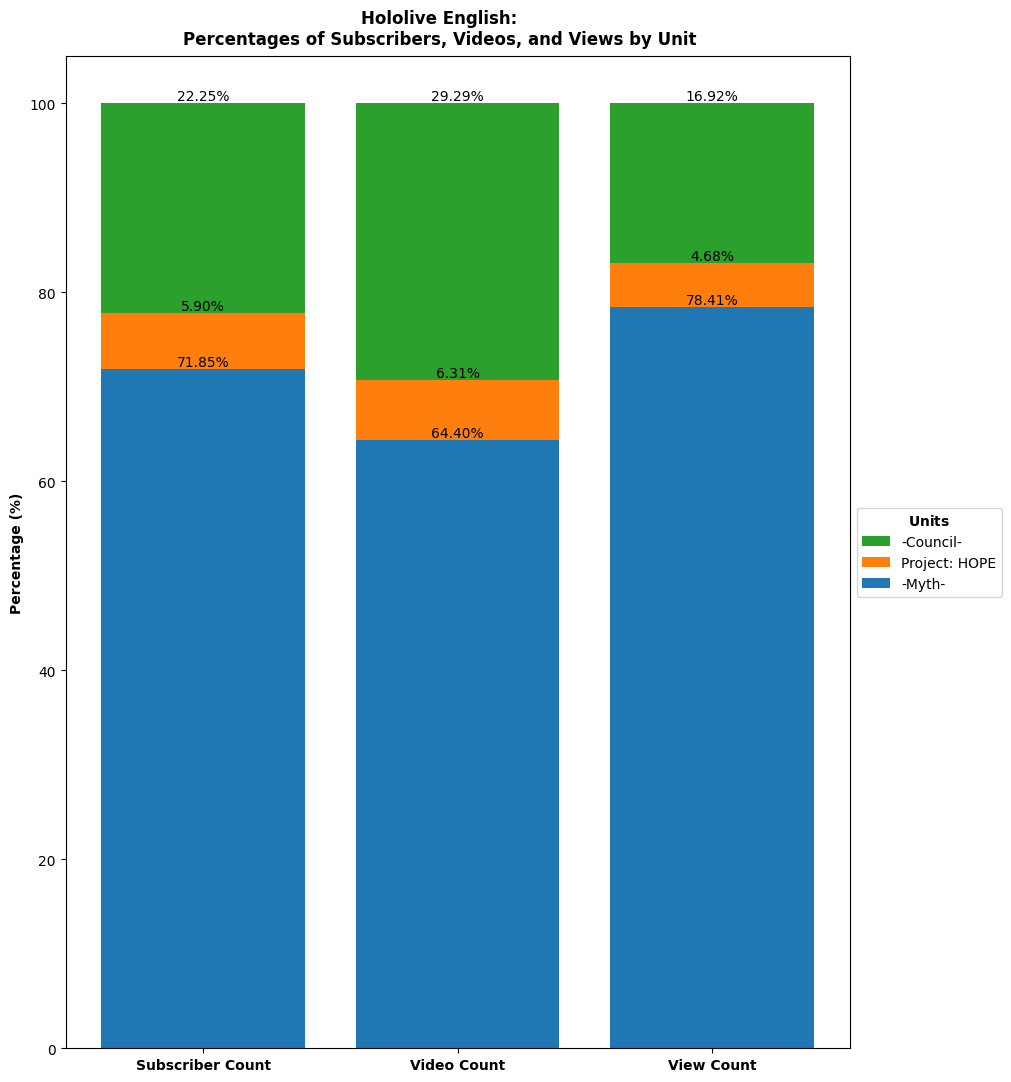

In [15]:
channel_stats_by_unit(member_channel_data, group = 'Hololive', branch = 'English', show='percentage')

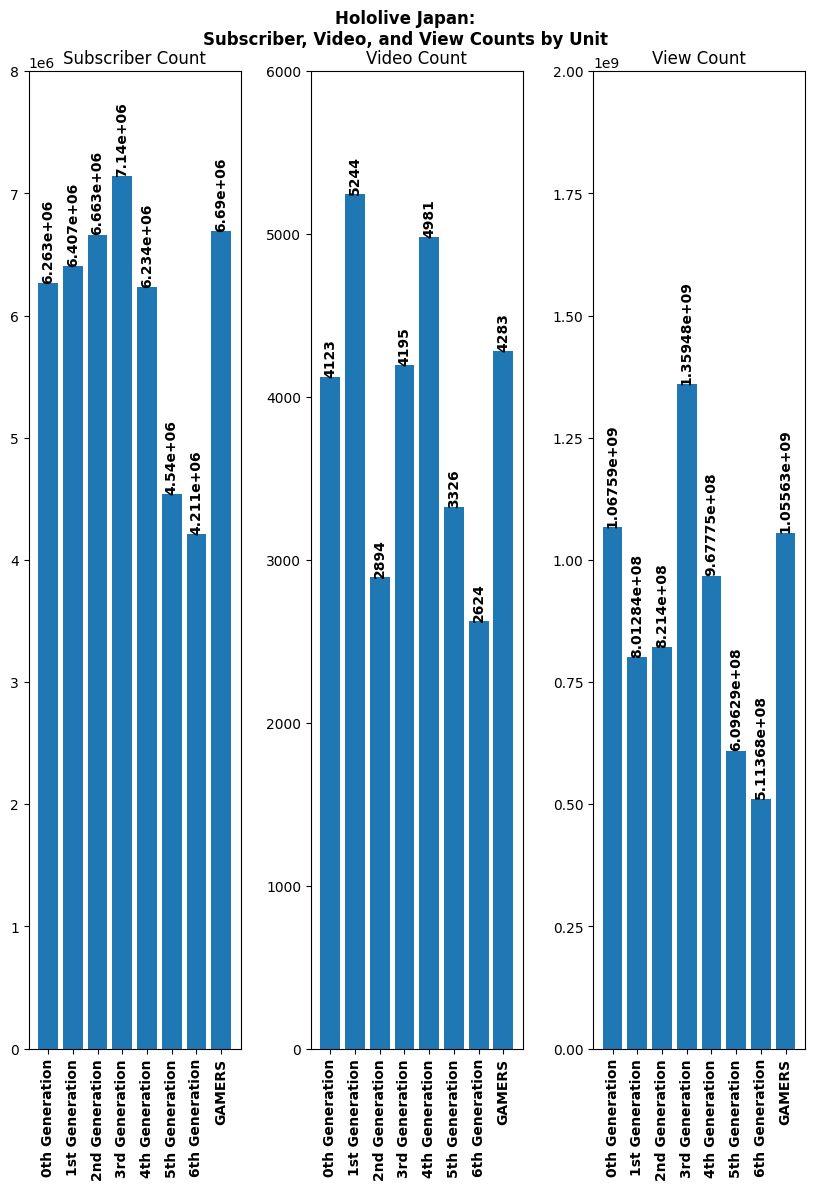

In [16]:
channel_stats_by_unit(member_channel_data, group='Hololive', branch='Japan', show='count')